# Module 08: Model Evaluation and Calibration (Full Model)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

date_beg = '2000-10-01'
date_end = '2020-09-30'

dt = 1.0 # Time step [day]
A = 250.0 # Watershed area [km^2]

# Snow-17 model parameters 
DD = 4.0
Tt = 0.0

# HBV model parameters
Sumax = 160.0 # Maximum upper soil zone capacity
FC = 0.4 # Soil field capacity
beta = 2.0 
C = 1.0
PWP = 0.05
L = 50.0
K0 = 0.075
K1 = 0.001
K2 = 0.005
Kperc = 0.05

# Initial conditions
Su0 = 100.0 # Upper soil zone storage [mm]
Sl0 = 300.0 # Lower soil zone storage [mm]


### 2. Define the Equations of the Model

In [2]:
def hbv_derivs(t,P,Ta,SWE,DD,Tt,Su,Sumax,Sl,FC,beta,C,PEm,Tm,PWP,L,K0,K1,Kperc,K2,A):

    # Calculate soil moisture
    SM = Su/Sumax
    
    # If SWE is greater than zero, there *may* be snowmelt
    if SWE>0.0:
        if Ta>Tt:
            Sm = DD*(Ta-Tt) # Snowmelt via degree-day factor
        else:
            Sm = 0.0 # No snowmelt if temperature does not exceed threshold
    else: # If there is no SWE, by definition there is no snowmelt
        Sm = 0.0
    
    # If there is precipitation, figure out it's phase
    SWE_i = SWE
    if P>0:
        if Ta<=Tt:
            SWE_i += P # All precip will be added to SWE storage
            Peff = 0.0 # There is no effective, liquid precipitation
        else:
            SWE_i = SWE
            Peff = (SM/FC)**beta*(P + Sm)
    else: # If P == 0, then
        SWE_i = SWE
        Peff = (SM/FC)**beta*(P + Sm)

    # If effective precipitation is less than precipitation and snowmelt, there is direct runoff
    if((Peff)<(P+Sm)):
        DRO = Peff
    else:
        DRO = 0.0
        
    # Evapotranspiration module
    # Get the month number
    mon = np.datetime64(t,'M').astype(int) % 12
    
    # Compute potential evapotranspiration based on climatology and air temperature
    PEa = max([(1 + C*(Ta - Tm[mon]))*PEm[mon],0.0]) 
    
    # Calculate actual evapotranspiration 
    if SM<PWP: # If soil moisture is below wilting point, scale actual evapotranspiration
        Ea = PEa*(SM/PWP)
    else: # If soil moisture greater than wilting point, actual ET equals potential
        Ea = PEa
        
    # Runoff module
    if Su<=L:
        Q0 = 0.0
    else:
        Q0 = K0*(Su-L) # Quick flow (happens at high upper zone moistures)
    Q1 = K1*Su # Slow flow
    Qperc = Kperc*Su # Percolation from upper to lower reservoir
    Q2 = K2*Sl # Base flow
    
    dSudt = ((P + Sm) - Peff) - Ea - Q0 - Q1 - Qperc # Mass balance equation of upper soil zone
    dSldt = Qperc - Q2 # Mass balance equation of lower soil zone

    Qs = Q0 + Q1 + Q2 # Streamflow
    
    return dSudt, dSldt, SWE_i, Sm, DRO, Ea, Qs # Return derivatives and other variables

### 3. Read in the Forcing and Observed Streamflow

In [3]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

df_forcing

,Date,temp,precip,Qcms,PET
Date,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,3.244371
...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,3.412351


### 4. Compute the seasonal cycle of PET and temperature

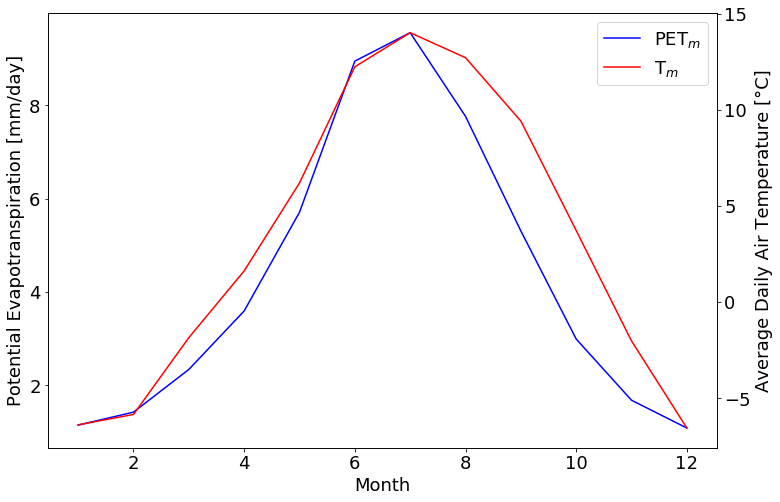

In [4]:
# Get the seasonal cycle of PET 
PETm = df_forcing['PET'].groupby(by=df_forcing.index.month).mean().values

# Get the seasonal cycle of temperature
Tm = df_forcing['temp'].groupby(by=df_forcing.index.month).mean().values

# Plot the PET and the temperature seasonal cycle
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)

ax2 = ax1.twinx()
lns1 = ax1.plot(np.arange(12)+1, PETm, 'b-',label='PET${}_m$')
lns2 = ax2.plot(np.arange(12)+1, Tm, 'r-',label='T${}_m$')

ax1.set_xlabel('Month')
ax1.set_ylabel('Potential Evapotranspiration [mm/day]')
ax2.set_ylabel('Average Daily Air Temperature [°C]')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs)

plt.show()


### 5. Get Forcing Variables as `Numpy` arrays

In [5]:
SimDates = df_forcing[date_beg:date_end]['Date'].values
P = df_forcing[date_beg:date_end]['precip'].values
Ta = df_forcing[date_beg:date_end]['temp'].values


### 6. Setup Containers for State Variables 

In [6]:
t = pd.date_range(start=date_beg, end=date_end, freq='1D')
Nt = t.size

Su    = np.zeros((Nt,1))
dSudt = np.zeros((Nt,1))
Sl    = np.zeros((Nt,1))
dSldt = np.zeros((Nt,1))
SWE   = np.zeros((Nt,1))
Sm    = np.zeros((Nt,1))
DRO   = np.zeros((Nt,1))
Ea    = np.zeros((Nt,1))
Qs    = np.zeros((Nt,1))

In [7]:
for i in np.arange(Nt):
    if(i==0):
        SWE_i = 0.0
        Su_i  = Su0
        Sl_i  = Sl0
    else:
        SWE_i = SWE[i-1]
        Su_i = Su[i-1]
        Sl_i = Sl[i-1]
    
    P_i  = P[i]
    Ta_i = Ta[i]
    
    dSudt_i,dSldt_i,SWE_ip1,Sm_ip1,DRO_ip1,Ea_ip1,Qs_ip1 = hbv_derivs(t[i],P_i,Ta_i,SWE_i,
                                                                 DD,Tt,Su_i,Sumax,Sl_i,FC,beta,C,
                                                                 PETm,Tm,PWP,L,K0,K1,Kperc,K2,A)
    Su[i]    = max([(Su_i + dSudt_i*dt),0.0])
    dSudt[i] = dSudt_i
    Sl[i]    = max([(Sl_i + dSldt_i*dt),0.0])
    dSldt[i] = dSldt_i
    SWE[i]   = max([(SWE_i - Sm_ip1),0.0])
    Sm[i]    = Sm_ip1
    DRO[i]   = DRO_ip1
    Ea[i]    = Ea_ip1
    Qs[i]    = Qs_ip1
    

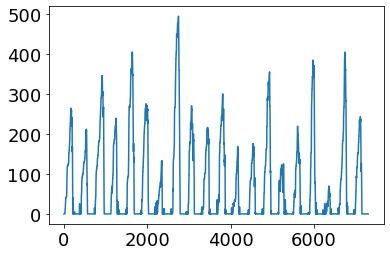

In [8]:
plt.plot(SWE)

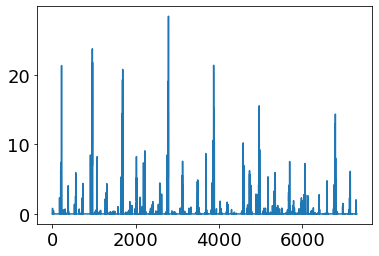

In [9]:
plt.plot(DRO)

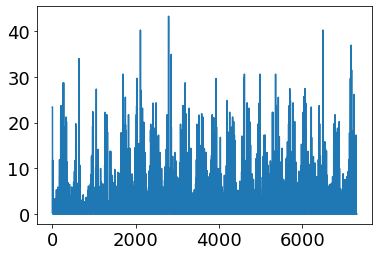

In [10]:
plt.plot(Ea)

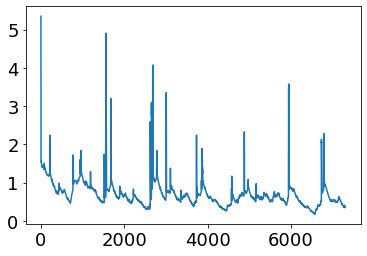

In [11]:
plt.plot(Qs)

In [12]:
dSudt_i[0]

0.0